In [54]:
 
import numpy as np 
import pandas as pd 

import numpy as np 
from tqdm import tqdm
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [55]:
train_img_dir = './training/train/'
# test_img_dir = './testing/test/jpeg/'
train = pd.read_csv('./training/train.csv')
# test = pd.read_csv('./testing/sample_submission.csv')

In [56]:
print(tf.__version__)

2.9.0


In [57]:
train.target.value_counts()

0    32542
1      584
Name: target, dtype: int64

In [58]:
benign = train[train['target']==0].sample(2500)
malignant = train[train['target']==1]
train=pd.concat([benign,malignant])
train=train.reset_index()

In [59]:
malignant.value_counts()

image_name    patient_id  sex     age_approx  anatom_site_general_challenge  diagnosis  benign_malignant  target
ISIC_0149568  IP_0962375  female  55.0        upper extremity                melanoma   malignant         1         1
ISIC_6931277  IP_9772004  male    90.0        torso                          melanoma   malignant         1         1
ISIC_6809586  IP_1173567  male    70.0        upper extremity                melanoma   malignant         1         1
ISIC_6829008  IP_9635781  female  50.0        lower extremity                melanoma   malignant         1         1
ISIC_6841294  IP_2352610  male    65.0        torso                          melanoma   malignant         1         1
                                                                                                                   ..
ISIC_3391427  IP_4956722  male    60.0        torso                          melanoma   malignant         1         1
ISIC_3394520  IP_1023029  female  15.0        torso          

In [60]:
benign.value_counts()

image_name    patient_id  sex     age_approx  anatom_site_general_challenge  diagnosis  benign_malignant  target
ISIC_0074268  IP_8723313  female  55.0        upper extremity                unknown    benign            0         1
ISIC_6704130  IP_9644384  female  25.0        lower extremity                unknown    benign            0         1
ISIC_6660247  IP_1840599  female  65.0        torso                          unknown    benign            0         1
ISIC_6663112  IP_0148558  female  50.0        lower extremity                unknown    benign            0         1
ISIC_6672519  IP_0787478  male    65.0        lower extremity                unknown    benign            0         1
                                                                                                                   ..
ISIC_3390387  IP_9147454  female  55.0        lower extremity                unknown    benign            0         1
ISIC_3407960  IP_8759634  female  45.0        upper extremity

In [61]:
SIZE=224
train_set = []
for image_name in train.image_name:
    train_set.append(tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(path = (train_img_dir + image_name + ".jpg"), color_mode = "rgb", target_size = (SIZE,SIZE)), dtype="float32"))

In [63]:
train["img"] = train_set
test["path"] = [(test_img_dir + image_name + ".jpg") for image_name in test.image_name]

NameError: name 'test' is not defined

In [64]:
train.head()

,index,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,img
0,17399,ISIC_5313579,IP_6601134,female,55.0,torso,unknown,benign,0,"[[[180.0, 139.0, 137.0], [181.0, 140.0, 134.0]..."
1,19589,ISIC_5950116,IP_1036531,male,70.0,head/neck,unknown,benign,0,"[[[152.0, 80.0, 104.0], [154.0, 80.0, 103.0], ..."
2,16564,ISIC_5069688,IP_2506801,female,75.0,lower extremity,unknown,benign,0,"[[[125.0, 90.0, 68.0], [128.0, 93.0, 71.0], [1..."
3,26854,ISIC_8140752,IP_1187676,male,65.0,lower extremity,unknown,benign,0,"[[[166.0, 110.0, 135.0], [158.0, 104.0, 127.0]..."
4,15724,ISIC_4807631,IP_8233849,male,55.0,torso,unknown,benign,0,"[[[183.0, 144.0, 137.0], [183.0, 141.0, 129.0]..."


In [65]:
train.shape

(3084, 10)

In [66]:
x_train, x_cross_validation, y_train, y_cross_validation = train_test_split(train.img, train.target, test_size=0.2, shuffle = True, random_state=42)

In [67]:
x_train.shape

(2467,)

In [68]:
# scale the pixels between 0 and 1
x_train /= 255
x_cross_validation /= 255
# redefine dtypes
y_train = np.array(y_train, dtype = "float32")
y_cross_validation = np.array(y_cross_validation, dtype = "float32")
x_train = np.array([np.array(val) for val in x_train])
x_cross_validation = np.array([np.array(val) for val in x_cross_validation])

In [69]:
batch_size = 32
num_classes = 2
epochs = 5

In [70]:
# focal loss
import keras.backend as K
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [73]:
# we will use Adam optimizer
opt = Adam(lr=1e-3)

#total number of iterations is always equal to the total number of training samples divided by the batch_size.
nb_train_steps = train.shape[0]//batch_size
nb_val_steps=x_cross_validation.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps,nb_val_steps))

Number of training and validation steps: 96 and 19


In [74]:
# Pixel Normalization and Image Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

# no need to create augmentation images for validation data, only rescaling the pixels
val_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
val_generator = val_datagen.flow(x_cross_validation, y_cross_validation, batch_size=32)

In [75]:

base_model = keras.applications.vgg19.VGG19(input_shape=(SIZE,SIZE,3),include_top=False,weights='imagenet')

In [76]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [77]:
base_model.trainable = False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [78]:
from tensorflow.keras import regularizers

inputs = keras.Input(shape=(SIZE,SIZE,3))
x = keras.applications.vgg19.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.003))(x)
x = layers.Dropout(0.35)(x)
x = layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.003))(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

In [79]:
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

In [86]:
model.compile(loss=focal_loss(), metrics=["accuracy"],optimizer=opt)

In [87]:
out = train["target"]

In [88]:



# from sklearn.utils import compute_class_weight
# classWeight = compute_class_weight('balanced', np.unique(out), out) 
# classWeight = dict(enumerate(classWeight))

In [89]:
from keras.callbacks import EarlyStopping
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1)


history = model.fit_generator(train_generator, steps_per_epoch=nb_train_steps, epochs=epochs,callbacks=[es],
                              validation_data=val_generator, validation_steps=nb_val_steps, 
                              verbose=1)

In [90]:
history = model.fit(train_generator, epochs=epochs,callbacks=[es], validation_data=val_generator,  verbose=1)

Epoch 1/5
78/78 [==============================] - 1054s 14s/step - loss: 0.0954 - accuracy: 0.8066 - val_loss: 0.0891 - val_accuracy: 0.8266
Epoch 2/5
78/78 [==============================] - 918s 12s/step - loss: 0.0885 - accuracy: 0.8066 - val_loss: 0.0824 - val_accuracy: 0.8266
Epoch 3/5
78/78 [==============================] - 959s 12s/step - loss: 0.0825 - accuracy: 0.8066 - val_loss: 0.0771 - val_accuracy: 0.8266
Epoch 4/5
78/78 [==============================] - 1138s 15s/step - loss: 0.0776 - accuracy: 0.8066 - val_loss: 0.0703 - val_accuracy: 0.8266
Epoch 5/5
78/78 [==============================] - 966s 12s/step - loss: 0.0736 - accuracy: 0.8066 - val_loss: 0.0669 - val_accuracy: 0.8266


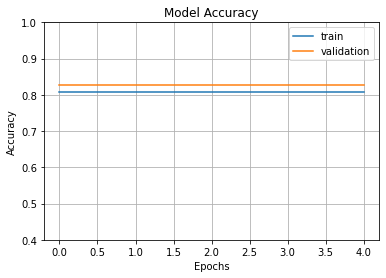

In [91]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

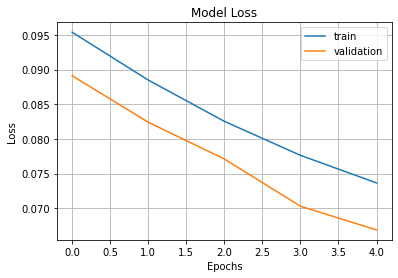

In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [93]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [94]:
predictions = model.predict(
      x=x_cross_validation
    , batch_size=10
    , verbose=0
) 

In [95]:
y_truth = y_cross_validation

In [96]:
for i in predictions :
   print(i)

[0.291026]
[0.29097903]
[0.29081607]
[0.29055256]
[0.29080483]
[0.29078957]
[0.29107538]
[0.2910184]
[0.29089472]
[0.2902431]
[0.29078102]
[0.29119575]
[0.2906161]
[0.29044747]
[0.29057533]
[0.29066542]
[0.2908155]
[0.29088023]
[0.29096776]
[0.29074627]
[0.2906792]
[0.2905817]
[0.2905287]
[0.29040298]
[0.29087853]
[0.29075697]
[0.29096758]
[0.29034665]
[0.29110184]
[0.29076952]
[0.29061288]
[0.29078737]
[0.2908825]
[0.29092345]
[0.29086834]
[0.2908552]
[0.2908626]
[0.29095757]
[0.29066736]
[0.29085326]
[0.29093564]
[0.29071423]
[0.29079998]
[0.29045838]
[0.2905955]
[0.2909884]
[0.29099047]
[0.2908141]
[0.2905821]
[0.29100072]
[0.29111248]
[0.29042935]
[0.2904618]
[0.29099396]
[0.29088163]
[0.29061818]
[0.29091942]
[0.29057857]
[0.2909606]
[0.29105693]
[0.29005507]
[0.29077163]
[0.2904415]
[0.2911841]
[0.29069903]
[0.29094777]
[0.29097605]
[0.29074523]
[0.2909739]
[0.2909562]
[0.29074478]
[0.29206607]
[0.2923209]
[0.29095212]
[0.2910434]
[0.29082653]
[0.291012]
[0.2909672]
[0.2912766]
[

In [97]:
rounded_predictions = np.argmax(predictions, axis=-1)

for i in rounded_predictions:
    print(i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [98]:
cm = confusion_matrix(y_true=y_truth, y_pred=rounded_predictions)

In [99]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [100]:
cm_plot_labels = ['Benign','melanoma']

Confusion matrix, without normalization
[[510   0]
 [107   0]]


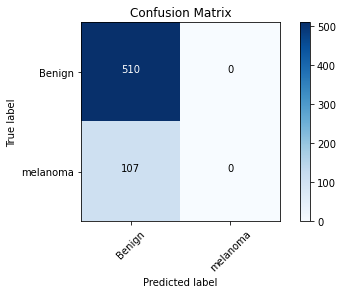

In [101]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [102]:
from tensorflow.keras.models import load_model
import cv2

model.save('2020_vgg.h5')






In [123]:
from keras.models import load_model



load_status = keras.models.load_model("2020_vgg.h5",custom_objects ={'focal_crossentropy':focal_loss()})

In [119]:
inp = r"./training/train/ISIC_0052212.jpg"


img=cv2.imread(inp)

print(img)
image=cv2.imread(inp)
image_resized= cv2.resize(image, (224,224))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)


[[[139 118 186]
  [142 121 189]
  [147 126 194]
  ...
  [130 113 164]
  [131 114 165]
  [131 114 165]]

 [[145 124 192]
  [148 127 195]
  [151 130 198]
  ...
  [131 114 165]
  [132 115 166]
  [132 115 166]]

 [[146 125 193]
  [148 127 195]
  [149 128 196]
  ...
  [133 115 168]
  [133 115 168]
  [133 115 168]]

 ...

 [[113 104 161]
  [113 104 161]
  [112 103 160]
  ...
  [ 85  72 116]
  [ 85  72 116]
  [ 85  72 116]]

 [[114 105 162]
  [114 105 162]
  [113 104 161]
  ...
  [ 85  72 116]
  [ 84  71 115]
  [ 84  71 115]]

 [[118 106 164]
  [117 105 163]
  [117 105 163]
  ...
  [ 84  72 114]
  [ 84  72 114]
  [ 84  72 114]]]
(1, 224, 224, 3)


In [124]:
nfkej = load_status.predict(image)
print(nfkej)

1/1 [==============================] - 1s 747ms/step
[[0.39544138]]
